In [ ]:
import warnings
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from statsmodels.stats.diagnostic import het_breuschpagan
from sqlalchemy import create_engine

from IPython.display import display_html

In [31]:
import seaborn as sns

In [32]:
# these packages are returning errors
#ModuleNotFoundError: No module named 'matplotlib.artist'

#import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline




In [33]:
#!pip install statsmodels --upgrade
#!pip3 install --user scipy==1.2.0
import statsmodels.api as sm

# Functions for possible use

In [34]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)


def top_corrs(df, column, n=10):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(10)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()


def na_summary(df, group_col, additional_cols=None):
    if additional_cols is None:
        additional_cols = ["log_saleprice"]

    additional_cols.append(group_col)
    # fmt: off
    df = (
      df[additional_cols]
        .fillna("NaN")
        .groupby(group_col)
        .agg(["size", "mean", "sum"])
    )
    display(df)
    # fmt: on


def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [35]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# No need for an open connection, because only doing a single query
engine.dispose()


df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the houseprices dataset from Kaggle that you've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: House Prices.

Investigate the data, and do any necessary data cleaning.
Explore the data and find some variables that you think would be useful in predicting house prices.
Build your initial model using these features and estimate the parameters using OLS.


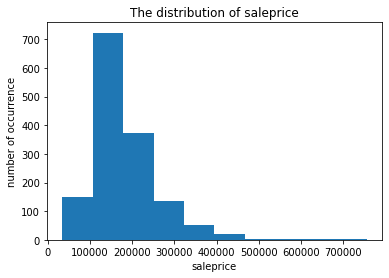

In [37]:
plt.hist(df.saleprice)
plt.title("The distribution of saleprice")
plt.xlabel("saleprice")
plt.ylabel("number of occurrence")
plt.show()
# saleprice is skewed right which is expected with the price of homes but relatively normal distribution. 

Transforming saleprice using the log makes the distribution more normal. 

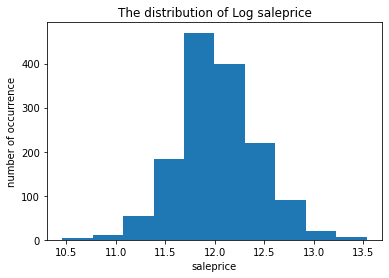

In [38]:
plt.hist(np.log(df['saleprice']))
plt.title("The distribution of Log saleprice")
plt.xlabel("saleprice")
plt.ylabel("number of occurrence")
plt.show()

Will use the log of our target variable.

18 of our 81 variables have nulls but our target variable is not one of them. 
Adding log of saleprice and dropping id column

In [39]:
df['log_saleprice'] = np.log(df['saleprice'])

In [40]:
df = df.drop(columns='saleprice')

In [41]:
df = df.drop(columns='id')

In [13]:
df.columns

Index(['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive'

In [14]:
# Looking at variable with the most nulls
df.isna().mean().sort_values(ascending=False).head(20)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagetype      0.055479
garagecond      0.055479
garagefinish    0.055479
garagequal      0.055479
garageyrblt     0.055479
bsmtfintype2    0.026027
bsmtexposure    0.026027
bsmtqual        0.025342
bsmtcond        0.025342
bsmtfintype1    0.025342
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
roofmatl        0.000000
dtype: float64

The poolqc variable is almost completely null along with miscfeature. Will see if they're related and why they're empty.
Alley and fence come in 3rd and 4th and don't seem to be related to each other or poolqc. Will look into whether these vars share common features to help explain missing values. If no relationship, then will consider dropping.

In [15]:
df.isnull().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagetype        81
garagecond        81
garagefinish      81
garagequal        81
garageyrblt       81
bsmtfintype2      38
bsmtexposure      38
bsmtqual          37
bsmtcond          37
bsmtfintype1      37
masvnrarea         8
masvnrtype         8
electrical         1
roofmatl           0
dtype: int64

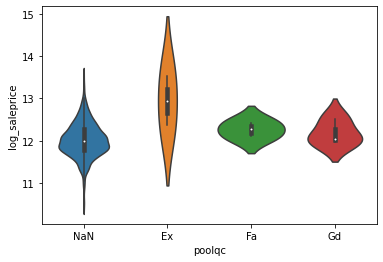

In [16]:
sns.violinplot('poolqc', 'log_saleprice', data=df.fillna('NaN'))
plt.show()

In [17]:
df["miscfeature"].fillna("NA").value_counts()

NA      1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: miscfeature, dtype: int64

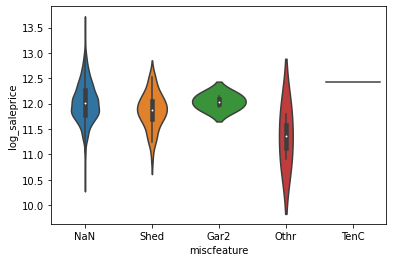

In [18]:

sns.violinplot('miscfeature', 'log_saleprice', data=df.fillna('NaN'))
plt.show()

In [19]:
df["alley"].fillna("NA").value_counts()

NA      1369
Grvl      50
Pave      41
Name: alley, dtype: int64

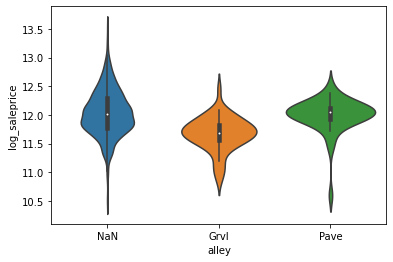

In [20]:
sns.violinplot('alley', 'log_saleprice', data=df.fillna('NaN'))
plt.show()

In [21]:
df["fence"].fillna("NA").value_counts()

NA       1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: fence, dtype: int64

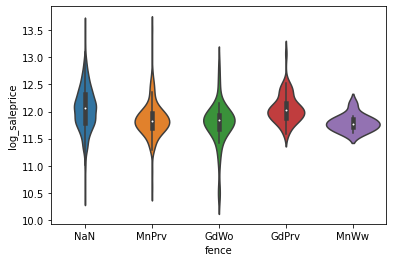

In [22]:
sns.violinplot('fence', 'log_saleprice', data=df.fillna('NaN'))
plt.show()

In [23]:
df["fireplacequ"].fillna("NA").value_counts()

NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: fireplacequ, dtype: int64

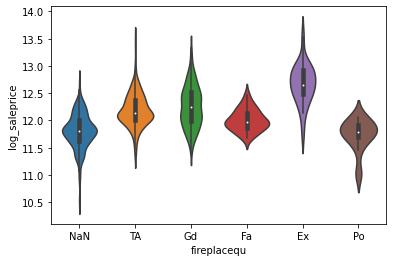

In [24]:
sns.violinplot('fireplacequ', 'log_saleprice', data=df.fillna('NaN'))
plt.show()

As shown, the top 5 variables by missing values above do not appear to be correlated with our target nor with each other.
Will remove them from table.

In [42]:
drop_cols = ["fence", "alley", "poolqc", "fireplacequ", "miscfeature"]
df = df.drop(columns=drop_cols)
df = df.dropna()

Detecting outliers in numerical columns. Dropping outliers greater than 2 from IQR would lose over half the data so will just remove the rows as noted below and the 5 columns as noted above.

In [26]:
# variables = ['mssubclass','lotarea','overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
#        'bsmtfinsf1','bsmtunfsf', 'totalbsmtsf','firstflrsf', 'secondflrsf',
#        'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
#        'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'garagearea',
#        'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold',
#        'yrsold']

# for col in variables:
#     for threshold in np.arange(1,5,0.5):
#         q75, q25 = np.percentile(df[col], [75 ,25])
#         iqr = q75 - q25
#         min_val = q25 - (iqr*threshold)
#         max_val = q75 + (iqr*threshold)
#         print("The score threshold is: {} for {}".format(threshold, col))
#         print("Number of outliers is: {}".format(
#             len((np.where((df[col] > max_val) | (df[col] < min_val))[0]))
#     ))

In [27]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

mssubclass         50.00000
lotfrontage        20.00000
lotarea          3780.50000
overallqual         2.00000
overallcond         1.00000
yearbuilt          50.00000
yearremodadd       38.00000
masvnrarea        171.75000
bsmtfinsf1        712.75000
bsmtfinsf2          0.00000
bsmtunfsf         576.00000
totalbsmtsf       529.50000
firstflrsf        519.50000
secondflrsf       729.00000
lowqualfinsf        0.00000
grlivarea         615.00000
bsmtfullbath        1.00000
bsmthalfbath        0.00000
fullbath            1.00000
halfbath            1.00000
bedroomabvgr        1.00000
kitchenabvgr        0.00000
totrmsabvgrd        2.00000
fireplaces          1.00000
garageyrblt        43.00000
garagecars          1.00000
garagearea        242.50000
wooddecksf        169.75000
openporchsf        68.00000
enclosedporch       0.00000
threessnporch       0.00000
screenporch         0.00000
poolarea            0.00000
miscval             0.00000
mosold              3.00000
yrsold              

In [28]:
# dropping values by IQR range eliminated over half the data so may not use this
#df = df[~((df < (Q1 - 5 * IQR)) |(df > (Q3 + 5 * IQR))).any(axis=1)]

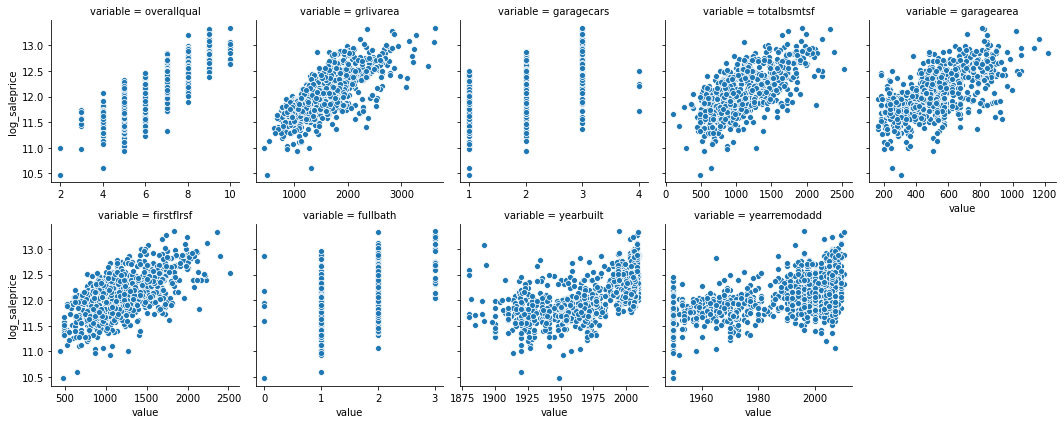

In [52]:
plot_top_corrs(df, "log_saleprice")

Dropping pattern breaking outliers in firstflrsf, grlivarea, garagearea and totalbsmtsf that will distort predictions.

In [46]:
df['firstflrsf'].sort_values(ascending=False).head(5)
df = df.drop([1298,523])


In [48]:
df['garagearea'].sort_values(ascending=False).head(10)
df = df.drop([581,1061])


In [49]:
df['grlivarea'].sort_values(ascending=False).head(10)
df = df.drop([1182,691])

In [51]:
df['totalbsmtsf'].sort_values(ascending=False).head(10)
df = df.drop([441])


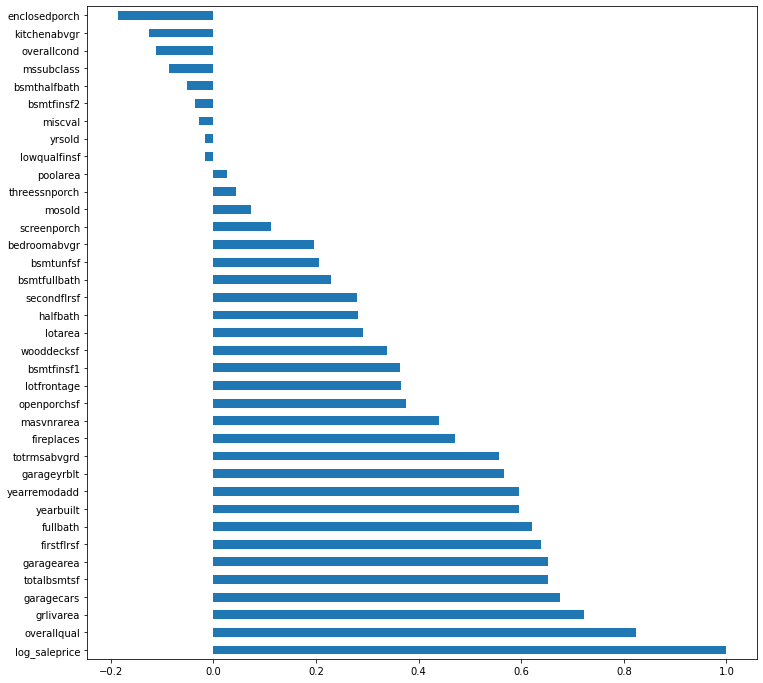

In [53]:
df.corr()['log_saleprice'].sort_values(ascending=False).plot(kind='barh',figsize=(12,12))

In [54]:
df.corr()['log_saleprice'].sort_values(ascending=False)

log_saleprice    1.000000
overallqual      0.824543
grlivarea        0.722344
garagecars       0.675944
totalbsmtsf      0.652987
garagearea       0.652015
firstflrsf       0.638636
fullbath         0.621147
yearbuilt        0.595583
yearremodadd     0.595288
garageyrblt      0.566074
totrmsabvgrd     0.557341
fireplaces       0.470608
masvnrarea       0.439792
openporchsf      0.374602
lotfrontage      0.365888
bsmtfinsf1       0.364456
wooddecksf       0.338426
lotarea          0.292073
halfbath         0.282367
secondflrsf      0.280246
bsmtfullbath     0.228234
bsmtunfsf        0.205748
bedroomabvgr     0.196883
screenporch      0.112418
mosold           0.073089
threessnporch    0.044108
poolarea         0.026674
lowqualfinsf    -0.015637
yrsold          -0.015681
miscval         -0.027988
bsmtfinsf2      -0.036173
bsmthalfbath    -0.051914
mssubclass      -0.086856
overallcond     -0.111469
kitchenabvgr    -0.125813
enclosedporch   -0.186896
Name: log_saleprice, dtype: float64

In [ ]:
Running AVOVA tests on categorical vars to find which are more significant. 

In [57]:
cat_cols = df.select_dtypes("O").copy()
anova_results = []
for col in cat_cols:
    groups = list(df[["log_saleprice", col]].groupby(col))
    samples = [group[1]["log_saleprice"] for group in groups]
    f, p = stats.f_oneway(*samples)

    anova_result = {"col": col, "f": f, "p": p}
    anova_results.append(anova_result)

anova_results_df = pd.DataFrame(anova_results).sort_values("f", ascending=False)
top_f = anova_results_df.head(10)
top_f

C:\Users\Mike\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:2959: RuntimeWarning: invalid value encountered in double_scalars
  msb = ssbn / dfbn


,col,f,p
17,exterqual,358.075197,1.642175e-161
20,bsmtqual,348.369737,2.559524e-158
29,kitchenqual,319.828863,1.137734e-148
32,garagefinish,298.047476,7.160393e-104
19,foundation,130.223359,8.147741e-91
27,centralair,106.822306,6.023118e-24
26,heatingqc,95.730375,9.224353e-70
16,masvnrtype,94.600715,2.220384e-54
31,garagetype,82.232369,2.990844e-73
23,bsmtfintype1,67.089543,3.994485e-61


Keeping only half the of top most significant categorical columns and removing the rest. Also keeping 

In [58]:
#cat_cols = df.select_dtypes("O").copy()
#keep_cols = ["exterqual", "kitchenqual", "bsmtqual", "garagefinish", "centralair"]
#drop_cols = [c for c in cat_cols.columns if c not in keep_cols]

drop_cat_col = ['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'extercond', 'foundation',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'electrical', 'functional', 'garagetype', 
       'garagequal', 'garagecond',
       'paveddrive', 'saletype', 'salecondition']

df = df.drop(columns=drop_cat_col)

In [59]:
df.select_dtypes('O').columns

Index(['exterqual', 'bsmtqual', 'centralair', 'kitchenqual', 'garagefinish'], dtype='object')

Encoding centralair to 1 or 0

In [60]:
df["centralair"] = (df["centralair"] == "Y").astype(int)

In [61]:
df.exterqual.value_counts()

TA    646
Gd    394
Ex     41
Fa      6
Name: exterqual, dtype: int64

In [62]:
df.kitchenqual.value_counts()

TA    527
Gd    454
Ex     85
Fa     21
Name: kitchenqual, dtype: int64

In [63]:
df.bsmtqual.value_counts()

TA    485
Gd    463
Ex    107
Fa     32
Name: bsmtqual, dtype: int64

In [64]:
df.garagefinish.value_counts()

Unf    485
RFn    331
Fin    271
Name: garagefinish, dtype: int64

In [65]:
#encoding variable

mapping = {"Unf": 1, "RFn": 2, "Fin": 3}
df[["garagefinish"]] = df[["garagefinish"]].replace(mapping)

In [66]:
df.garagefinish.value_counts()

1    485
2    331
3    271
Name: garagefinish, dtype: int64

In [67]:
df.centralair.value_counts()

1    1029
0      58
Name: centralair, dtype: int64

Three quality vars have the same categories so we can encode them all the same way. 

In [68]:
mapping = {"TA": 1, "Gd": 2, "Ex": 3, "Fa": 4}

df[["exterqual", "kitchenqual", "bsmtqual"]] = df[["exterqual", "bsmtqual", "kitchenqual"]].replace(mapping)

In [69]:
top_corrs(df, column='log_saleprice')

,corr,abs_corr
log_saleprice,1.000000,1.000000
overallqual,0.824543,0.824543
grlivarea,0.722344,0.722344
garagecars,0.675944,0.675944
totalbsmtsf,0.652987,0.652987
garagearea,0.652015,0.652015
firstflrsf,0.638636,0.638636
exterqual,0.621226,0.621226
fullbath,0.621147,0.621147
yearbuilt,0.595583,0.595583


In [70]:
df.columns

Index(['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'masvnrarea', 'exterqual', 'bsmtqual',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'centralair',
       'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd', 'fireplaces',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'log_saleprice'],
      dtype='object')

Removing all num columns except top 10 correlated with target variable.

In [71]:
df_cleaned = df[['exterqual', 'bsmtqual', 'centralair', 'kitchenqual', 'garagefinish', 'totalbsmtsf', 'grlivarea'
             , 'overallqual', 'garagecars', 'garagearea', 'firstflrsf', 'fullbath' , 'yearbuilt', 'yearremodadd'
             , 'garageyrblt', 'log_saleprice']]
df_cleaned.head()

,exterqual,bsmtqual,centralair,kitchenqual,garagefinish,totalbsmtsf,grlivarea,overallqual,garagecars,garagearea,firstflrsf,fullbath,yearbuilt,yearremodadd,garageyrblt,log_saleprice
0,2,2,1,2,2,856,1710,7,2,548,856,2,2003,2003,2003.0,12.247694
1,1,1,1,2,2,1262,1262,6,2,460,1262,2,1976,1976,1976.0,12.109011
2,2,2,1,2,2,920,1786,7,2,608,920,2,2001,2002,2001.0,12.317167
3,1,2,1,1,1,756,1717,7,3,642,961,1,1915,1970,1998.0,11.849398
4,2,2,1,2,2,1145,2198,8,3,836,1145,2,2000,2000,2000.0,12.429216


In [72]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1087 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   exterqual      1087 non-null   int64  
 1   bsmtqual       1087 non-null   int64  
 2   centralair     1087 non-null   int32  
 3   kitchenqual    1087 non-null   int64  
 4   garagefinish   1087 non-null   int64  
 5   totalbsmtsf    1087 non-null   int64  
 6   grlivarea      1087 non-null   int64  
 7   overallqual    1087 non-null   int64  
 8   garagecars     1087 non-null   int64  
 9   garagearea     1087 non-null   int64  
 10  firstflrsf     1087 non-null   int64  
 11  fullbath       1087 non-null   int64  
 12  yearbuilt      1087 non-null   int64  
 13  yearremodadd   1087 non-null   int64  
 14  garageyrblt    1087 non-null   float64
 15  log_saleprice  1087 non-null   float64
dtypes: float64(2), int32(1), int64(13)
memory usage: 140.1 KB


In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df_cleaned.corr(),vmin = -1, vmax = 1, annot=True)

In [76]:
print_vif(df_cleaned.drop(columns=["log_saleprice",'totalbsmtsf','garagecars','garageyrblt']))

VIF results
-------------------------------
const           21146.736740
exterqual           2.321822
bsmtqual            1.636435
centralair          1.235948
kitchenqual         1.520557
garagefinish        1.800151
grlivarea           2.553662
overallqual         3.254714
garagearea          1.830338
firstflrsf          1.617177
fullbath            2.279434
yearbuilt           2.925467
yearremodadd        2.006405
dtype: float64
-------------------------------



Based on VIF, dropping 3 variables ['totalbsmtsf','garagecars','garageyrblt']

In [77]:
# creating training and testing data
X = df_cleaned.drop(columns = ['log_saleprice'])
y = df_cleaned['log_saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [78]:
model = LinearRegression()
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Train Score: 0.8641202015974871
Test Score: 0.878627919864138


In [79]:
X_train_const = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_const).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     361.6
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:44:20   Log-Likelihood:                 456.46
No. Observations:                 869   AIC:                            -880.9
Df Residuals:                     853   BIC:                            -804.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.6829      0.767      6.107      0.000       3.178       6.188
exterqual       -0.0050      0.012     -0.400      0.689      -0.029       0.019
bsmtqual         0.0169      0.009      1.909      0.057      -0.000       0.034
centralair       0.1809      0.025      7.191      0.000       0.131       0.230
kitchenqual      0.0150      0.008      1.887      0.060      -0.001       0.031
garagefinish     0.0272      0.008      3.229      0.001       0.011       0.044
totalbsmtsf      0.0002    3.4e-05      5.576      0.000       0.000       0.000
grlivarea        0.0003   1.69e-05     16.610      0.000       0.000       0.000
overallqual      0.0808      0.007     12.130      0.000       0.068       0.094
garagecars       0.0096      0.016      0.596      0.551      -0.022       0.041
garagearea       0.0002   5.66e-05      3.747      0.000       0.000       0.000
firstflrsf    1.048e-05   3.43e-05      0.306      0.760   -5.68e-05    7.78e-05
fullbath        -0.0223      0.014     -1.623      0.105      -0.049       0.005
yearbuilt        0.0014      0.000      4.056      0.000       0.001       0.002
yearremodadd     0.0024      0.000      6.958      0.000       0.002       0.003
garageyrblt     -0.0008      0.000     -2.087      0.037      -0.002   -4.88e-05
==============================================================================
Omnibus:                      176.838   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              606.429
Skew:                          -0.954   Prob(JB):                    2.07e-132
Kurtosis:                       6.620   Cond. No.                     6.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
pred_df = X_test.copy()
pred_df["actual"] = np.exp(y_test)
pred_df = pred_df.reset_index()

pred_df["predicted"] = np.exp(model.predict(X_test))

pred_df["residual"] = pred_df["predicted"] - pred_df["actual"]
pred_df["abs_residual"] = pred_df["residual"].abs()
pred_df["perc_residual"] = pred_df["abs_residual"] / pred_df["actual"]

print(f'Mean Absolute Error: ${pred_df["abs_residual"].mean():.2f}')
print(f'Mean Absolute Percent Error: {pred_df["perc_residual"].mean() * 100:.2f}%')

Mean Absolute Error: $18355.71
Mean Absolute Percent Error: 10.08%


In [86]:
predictions = model.predict(X_test)
errors = y_test - predictions

print("Mean of the errors in the model is: {}".format(np.mean(errors)))

Mean of the errors in the model is: 0.0007868070956752103


Checking on assumptions of the model

In [85]:
# null hypothesis: data is homoscedastic
true_residuals = lm.resid
_, p, _, _ = het_breuschpagan(true_residuals, X_train_const)
p

1.3493339856968349e-05

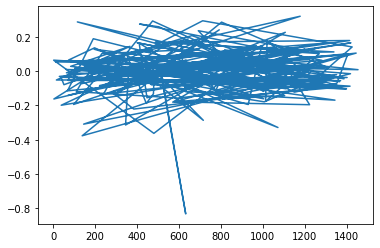

In [87]:
plt.plot(errors)
plt.show()

C:\Users\Mike\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:660: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\Mike\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


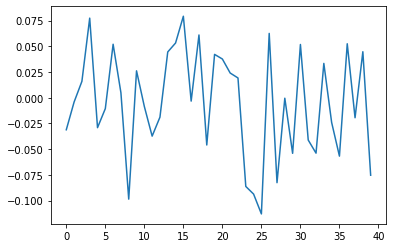

In [88]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

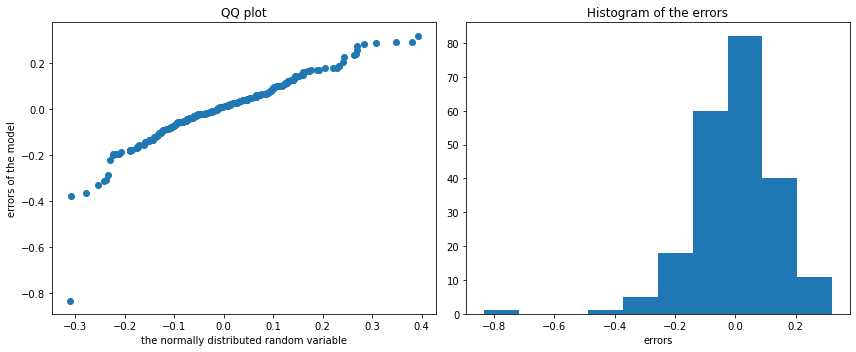

In [89]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # Sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()